In [1]:
import torch
import cv2
import numpy as np
import os

In [2]:
device = torch.device("cuda")

In [3]:
import argparse
import importlib
from v_diffusion import make_beta_schedule
from moving_average import init_ema_model
from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy
import torch
import os
from train_utils import p_sample_loop
import cv2
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

class Stub:
    pass

args = Stub()
args.module = "celeba_ae_128m"

args.time_scale = 4
args.checkpoint = "./checkpoints/celeba_ae_128m_vast/original_1c/checkpoint.pt"
args.batch_size = 4
args.diffusion = "GaussianDiffusion"
args.clipped_sampling = True
args.clipping_value = 1000
args.eta = 0

In [4]:
M = importlib.import_module(args.module)
make_model = getattr(M, "make_model")

In [5]:
teacher_ema = make_model().to(device)

def make_diffusion(args, model, n_timestep, time_scale, device):
    betas = make_beta_schedule("cosine", cosine_s=8e-3, n_timestep=n_timestep).to(device)
    M = importlib.import_module("v_diffusion")
    D = getattr(M, args.diffusion)
    sampler = "ddpm"
    if args.clipped_sampling:
        sampler = "clipped"
    return D(model, betas, time_scale=time_scale, sampler=sampler)

teacher = make_model().to(device)

ckpt = torch.load(args.checkpoint)
teacher.load_state_dict(ckpt["G"])
n_timesteps = ckpt["n_timesteps"]//args.time_scale
time_scale = ckpt["time_scale"]*args.time_scale
del ckpt
print("Model loaded.")

Model loaded.


In [6]:
teacher_diffusion = make_diffusion(args, teacher, n_timesteps, time_scale, device)

In [7]:
image_size = deepcopy(teacher.image_size)
image_size[0] = args.batch_size


In [8]:
from styleflow.flow import cnf
prior = cnf(512, '512-512-512-512-512', 29, 1)
prior.load_state_dict(torch.load('./checkpoints/styleflow/007000_00.pt'))
prior.eval()

Training T : 1.0
Number of trainable parameters of Point CNF: 1765377


SequentialFlow(
  (chain): ModuleList(
    (0): MovingBatchNorm1d(512, eps=0.0001, decay=0.1, bn_lag=0, affine=True)
    (1): CNF(
      (odefunc): ODEfunc(
        (diffeq): ODEnet(
          (layers): ModuleList(
            (0): ConcatSquashLinear(
              (_layer): Linear(in_features=512, out_features=512, bias=True)
              (_hyper_bias): Linear(in_features=30, out_features=512, bias=False)
              (_hyper_gate): Linear(in_features=30, out_features=512, bias=True)
            )
            (1): ConcatSquashLinear(
              (_layer): Linear(in_features=512, out_features=512, bias=True)
              (_hyper_bias): Linear(in_features=30, out_features=512, bias=False)
              (_hyper_gate): Linear(in_features=30, out_features=512, bias=True)
            )
            (2): ConcatSquashLinear(
              (_layer): Linear(in_features=512, out_features=512, bias=True)
              (_hyper_bias): Linear(in_features=30, out_features=512, bias=False)
       

In [9]:
from train_styleflow import FIELDS, read_annotations

In [10]:
attributes_file = "./data/CelebAMask-HQ-attribute-anno.txt"
pose_file = "./data/CelebAMask-HQ-pose-anno.txt"
annotations = {}
read_annotations(attributes_file, annotations)
read_annotations(pose_file, annotations)

In [11]:
images_dir = "./data/"
latents_dir = "./data/"

In [12]:
f_name = "1.jpg"

In [13]:
latents = torch.load(os.path.join(latents_dir, f_name + ".pt"))["latents"][:, None]

In [14]:
latents.shape

torch.Size([1, 1, 512])

In [15]:
attrs = []
file_attrs = annotations[f_name]
for f in FIELDS:
    attrs.append(file_attrs[f])
attrs = torch.FloatTensor(attrs)[None, :, None]

In [16]:
attrs.shape

torch.Size([1, 29, 1])

In [17]:
zero_padding = torch.zeros(1, 29, 1).cuda()

In [18]:
fws = prior(latents[None, ...].to(device), attrs[None, ...].to(device), zero_padding)

In [19]:
fws[0].shape

torch.Size([1, 1, 1, 512])

In [20]:
FIELDS

['Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'No_Beard',
 'Pale_Skin',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Wavy_Hair',
 'Yaw',
 'Pitch',
 'Raw']

In [21]:
FIELD_INDEXES = {}
for f in FIELDS:
    FIELD_INDEXES[f] = len(FIELD_INDEXES)

In [22]:
from sample import make_visualization, calc_latents
from PIL import Image
from IPython.display import display

In [23]:
image_path = os.path.join(images_dir, f_name)

In [24]:
latents_a, image_a = calc_latents(teacher, image_path, device)

In [25]:
print("Reverse DDIM sampling for finding x_0...")
a0 = teacher_diffusion.reverse_sample(latents_a, image_a.to(device), {}, need_tqdm=True)


Reverse DDIM sampling for finding x_0...


100%|██████████| 255/255 [00:12<00:00, 20.44it/s]


In [26]:
new_attrs = attrs.clone()
new_attrs[0, FIELD_INDEXES["Male"]] = 3
new_attrs[0, FIELD_INDEXES["Blond_Hair"]] = -1
new_attrs[0, FIELD_INDEXES["Black_Hair"]] = 1
new_attrs[0, FIELD_INDEXES["Smiling"]] = -1
new_attrs[0, FIELD_INDEXES['Mouth_Slightly_Open']] = -1

In [27]:
rev = prior(fws[0], new_attrs.to(device), zero_padding, True)[0][0, 0]

In [28]:
new_latents = torch.cat([latents[0].to(device), rev], 0)
img = make_visualization(a0.repeat(new_latents.shape[0], 1, 1, 1), new_latents.to(device), teacher_diffusion, device, teacher.image_size, need_tqdm=True, eta=args.eta, clip_value=args.clipping_value)


256it [00:22, 11.22it/s]


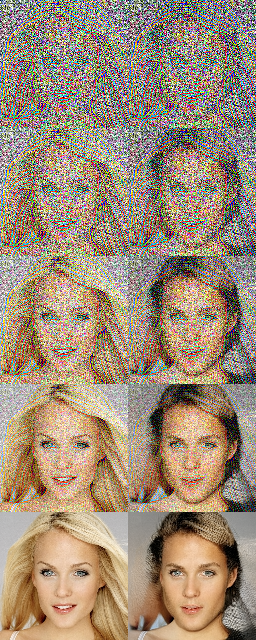

In [29]:
display(Image.fromarray(img[:,:,::-1]))